In [2]:
"""
Script written by Andrew Rohne. This prepares updates for the CDAP model for ONLY FT, PT, U, NW, and R - skips 
SchPD, SchD, and PS because they were not in use in Met Coucil.

Needs: 
  1: Visualizer Survey folder - reads one of the CSVs
  2: ActivitySim person output

How To Use:
  1: Set the project_dir (cell 2) to the base of your project - this should include the visualizer summary inputs and the model data
  2: Set the output folder (where some CSV files are saved)
  2: Fix the census_auto_ownership_file (text should be relative to project_dir)
  3: Fix the hh file (again, should be relative to project_dir)
  4: You'll probably need to update some fields
  

"""
import sys
import pandas as pd
import os
import numpy as np
pd.options.display.max_columns = 50
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
 
ASIM_OUTPUT = r"E:\Met_Council\metc-asim-model\Base_2018\activitysim\output"
ASIM_CONFIGS_PATH = r'E:\Met_Council\metc-asim-model\source\activitysim\configs'
SURVEY_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\base'
SYNPOP_INPUT = r'E:\Met_Council\metc-asim-model\Input\socioeconomic'
SURVEY_PATH = r'E:\Met_Council\survey_data\Phase1\SPA_Inputs'
CENSUS_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\census'

# asim_out_folder = 'E:\\Projects\\Clients\\MetCouncilASIM\\tasks\\metc-asim-model\\activitysim\\output'
# vis_survey_summaries = 'E:\\Projects\\Clients\\MetCouncilASIM\\tasks\\metc-asim-model\\Visualizer\\data\\base'
# asim_config_folder = 'E:\\Projects\\Clients\\MetCouncilASIM\\tasks\\metc-asim-model\\activitysim\\configs'

PERTYPEMAP = {1: 'FT Worker', 2: 'PT Worker', 3: 'Univ Student', 4: 'Nonworker', 5: 'Retired', 6: 'Driving Age Student', 7: 'Pre-Driving Student', 8: 'Preschool'}

mtfMap = {1: 'work1', 2: 'work2', 3: 'school1', 4: 'school2', 5: 'work_and_school'}
MTF_LEVEL = {v: k for k, v in mtfMap.items()}

coef_map = {1: {'work1': 'coef_ft_worker_work1_asc', 'work2': 'coef_ft_worker_work2_asc', 'school1': 'coef_ft_worker_school1_asc', 'school2': 'coef_ft_worker_school2_asc', 'work_and_school': 'coef_ft_worker_work_and_school_asc'},
            2: {'work1': 'coef_pt_worker_work1_asc', 'work2': 'coef_pt_worker_work2_asc', 'school1': 'coef_pt_worker_school1_asc', 'school2': 'coef_pt_worker_school2_asc', 'work_and_school': 'coef_pt_worker_work_and_school_asc'},
            3: {'work1': 'coef_univ_work1_asc', 'work2': 'coef_univ_work2_asc', 'school1': 'coef_univ_school1_asc', 'school2': 'coef_univ_school2_asc', 'work_and_school': 'coef_univ_work_and_school_asc'},
            6: {'work1': 'coef_driving_age_child_work1_asc', 'work2': 'coef_driving_age_child_work2_asc', 'school1': 'coef_driving_age_child_school1_asc', 'school2': 'coef_driving_age_child_school2_asc', 'work_and_school': 'coef_driving_age_child_work_and_school_asc'},
            7: {'work1': 'coef_pre_driving_age_work1_asc', 'work2': 'coef_pre_driving_age_work2_asc', 'school1': 'coef_pre_driving_age_school1_asc', 'school2': 'coef_pre_driving_age_school2_asc', 'work_and_school': 'coef_pre_driving_age_work_and_school_asc'},
            8: {'work1': 'coef_preschool_work1_asc', 'work2': 'coef_preschool_work2_asc', 'school1': 'coef_preschool_school1_asc', 'school2': 'coef_preschool_school2_asc', 'work_and_school': 'coef_preschool_work_and_school_asc'}
    
}

In [3]:
# Read targets and current
target = pd.read_csv(os.path.join(SURVEY_SUMMARY_PATH, "mtfSummary.csv"), comment = "#").rename(columns = {'freq': 'ObsN'})
person = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_persons.csv"))
hh = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_households.csv"))
model_sample_rate = hh['sample_rate'].value_counts().index[0]

In [4]:
mtfSummary = person.groupby(['ptype', 'mandatory_tour_frequency']).agg(ModN = ('person_id', 'count')).reset_index()
mtfSummary['ModN'] = mtfSummary['ModN'] / model_sample_rate
target['mandatory_tour_frequency'] = target['mtf'].map(mtfMap)
compare = mtfSummary.merge(target, left_on = ['ptype', 'mandatory_tour_frequency'], right_on = ['PERTYPE', 'mandatory_tour_frequency'], how = 'outer')
compare['ptype'].fillna(compare['PERTYPE'], inplace = True)
compare['ObsN'].fillna(0, inplace = True)
compare['ModN'].fillna(0, inplace = True)
gpSum = compare.groupby('ptype').agg(ModTot = ('ModN', 'sum'), ObsTot = ('ObsN', 'sum')).reset_index()
compare = compare.merge(gpSum, on = "ptype")
compare['ModPct'] = compare['ModN'] / compare['ModTot']
compare['ObsPct'] = compare['ObsN'] / compare['ObsTot']
compare['coef_adj'] = np.log(compare['ObsPct'] / compare['ModPct'], where = ((compare['ModPct'] > 0) & (compare['ObsPct'] > 0)))
compare[['ptype', 'mandatory_tour_frequency', 'ObsN', 'ModN', 'ObsPct', 'ModPct', 'coef_adj']].style.format(formatter = {'ObsN': "{:,.0f}", 'ModN': "{:,.0f}", 'ObsPct': "{:.2%}".format, 'ModPct': "{:.2%}".format}).to_excel(r"debug\tour_mtf.xlsx")
compare[['ptype', 'mandatory_tour_frequency', 'ObsN', 'ModN', 'ObsPct', 'ModPct', 'coef_adj']].style.format(formatter = {'ObsN': "{:,.0f}", 'ModN': "{:,.0f}", 'ObsPct': "{:.2%}".format, 'ModPct': "{:.2%}".format})

,ptype,mandatory_tour_frequency,ObsN,ModN,ObsPct,ModPct,coef_adj
0,1.000000,work1,"577,799","608,309",94.02%,91.88%,0.023025
1,1.000000,work2,"36,203","53,773",5.89%,8.12%,-0.321163
2,1.000000,school1,539,0,0.09%,0.00%,0.000000
3,1.000000,school2,20,0,0.00%,0.00%,0.000000
4,2.000000,work1,"90,759","118,495",91.94%,93.63%,-0.018165
5,2.000000,work2,"7,956","8,067",8.06%,6.37%,0.234613
6,3.000000,school1,"24,242","20,742",45.57%,49.13%,-0.075179
7,3.000000,school2,"2,248","1,814",4.23%,4.30%,-0.016949
8,3.000000,work1,"25,085","18,567",47.16%,43.98%,0.069761
9,3.000000,work2,384,268,0.72%,0.63%,0.128714


C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_13356\1622689745.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + pi)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_13356\1622689745.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + pi)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_13356\1622689745.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + pi)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_13356\1622689745.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated s

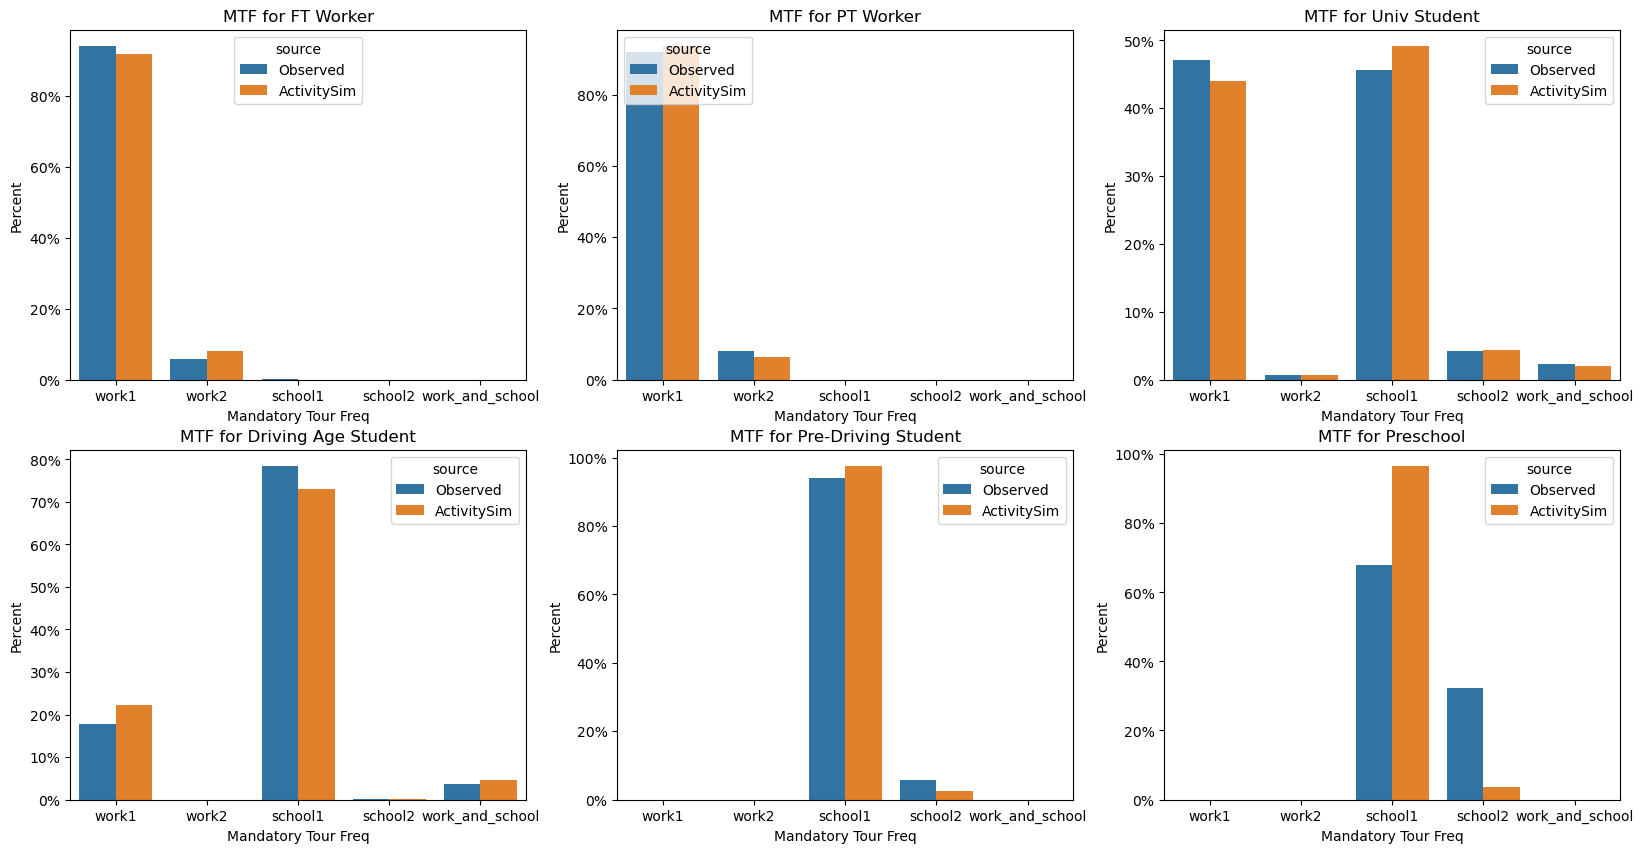

In [5]:
source_dict = {'ObsPct': 'Observed', 'ModPct': 'ActivitySim'}
plot_data = pd.melt(compare[['ptype', 'mandatory_tour_frequency', 'ObsPct', 'ModPct']], value_name = 'percent', value_vars = ['ObsPct', 'ModPct'], id_vars = ['ptype', 'mandatory_tour_frequency'])
plot_data['source'] = plot_data['variable'].map(source_dict)
plot_data['mtf_level'] = plot_data['mandatory_tour_frequency'].map(MTF_LEVEL)
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
plot_idx = 230

for pi, ptype in zip(np.arange(1, 7), [1, 2, 3, 6, 7, 8]):
    ax = plt.subplot(plot_idx + pi)
    plot_dat = pd.DataFrame({'mtf_level': [1, 2, 3, 4, 5]}).merge(plot_data[plot_data['ptype'] == ptype], how = 'left', on = 'mtf_level')
    sns.barplot(data = plot_dat, x = 'mtf_level', y = 'percent', hue = 'source')
    plt.title(f"MTF for {PERTYPEMAP[ptype]}")
    # plt.xticks(fontsize=16, rotation = 90)
    # plt.yticks(fontsize=16)
    plt.ylabel('Percent')
    plt.xlabel('Mandatory Tour Freq')
    ax.set_xticks([0, 1, 2, 3, 4], labels = mtfMap.values())
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0%}'))

In [6]:
asim_config = pd.read_csv(os.path.join(ASIM_CONFIGS_PATH,'mandatory_tour_frequency_coeffs.csv'))
asim_config[asim_config['coefficient_name'].str.contains('asc')]


,coefficient_name,value,constrain
0,coef_ft_worker_work2_asc,-2.413708,F
1,coef_pt_worker_work2_asc,-2.661649,F
2,coef_univ_school2_asc,-3.534336,F
3,coef_univ_work1_asc,2.155513,F
4,coef_univ_work2_asc,-2.736091,F
5,coef_univ_work_and_school_asc,-1.615953,F
6,coef_driving_age_child_school2_asc,-6.365850,F
7,coef_driving_age_child_work1_asc,-1.862419,F
8,coef_driving_age_child_work_and_school_asc,-3.057978,F
9,coef_pre_driving_age_child_school2_asc,-3.970300,F


# Full-Time Workers

In [7]:
asimcfg_ft = asim_config[asim_config['coefficient_name'].str.contains('ft\_worker.+asc')]
compare_ft = compare[compare['ptype'] == 1]
compare_ft['coefficient_name'] = compare_ft['mandatory_tour_frequency'].map(coef_map[1])
compare_ft = compare_ft.merge(asimcfg_ft, on = 'coefficient_name')
#asimcfg_ft
compare_ft['new_coef'] = compare_ft['value'] + compare_ft['coef_adj']

compare_ft[['mandatory_tour_frequency', 'ModPct', 'ObsPct', 'coef_adj']]

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_13356\636628803.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_ft['coefficient_name'] = compare_ft['mandatory_tour_frequency'].map(coef_map[1])


,mandatory_tour_frequency,ModPct,ObsPct,coef_adj
0,work2,0.081218,0.058908,-0.321163


In [8]:
compare_ft[['coefficient_name', 'new_coef', 'constrain']].to_csv(sys.stdout, index = False)

coefficient_name,new_coef,constrain
coef_ft_worker_work2_asc,-2.734870871334827,F


# Part-Time Workers

In [9]:
asimcfg_pt = asim_config[asim_config['coefficient_name'].str.contains('pt\_worker.+asc')]
compare_pt = compare[compare['ptype'] == 2]
compare_pt['coefficient_name'] = compare_pt['mandatory_tour_frequency'].map(coef_map[2])
compare_pt = compare_pt.merge(asimcfg_pt, on = 'coefficient_name')
#asimcfg_ft
compare_pt['new_coef'] = compare_pt['value'] + compare_pt['coef_adj']

compare_pt[['coefficient_name', 'new_coef', 'constrain']].to_csv(sys.stdout, index = False)

coefficient_name,new_coef,constrain
coef_pt_worker_work2_asc,-2.4270356406880467,F


C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_13356\3456883487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_pt['coefficient_name'] = compare_pt['mandatory_tour_frequency'].map(coef_map[2])


# University Students

In [10]:
asimcfg_u = asim_config[asim_config['coefficient_name'].str.contains('univ.+asc')]
compare_u = compare[compare['ptype'] == 3]
compare_u['coefficient_name'] = compare_u['mandatory_tour_frequency'].map(coef_map[3])
compare_u = compare_u.merge(asimcfg_u, on = 'coefficient_name')
compare_u['new_coef'] = compare_u['value'] + compare_u['coef_adj']

compare_u[['mandatory_tour_frequency', 'ModPct', 'ObsPct', 'coef_adj']]

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_13356\125818102.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_u['coefficient_name'] = compare_u['mandatory_tour_frequency'].map(coef_map[3])


,mandatory_tour_frequency,ModPct,ObsPct,coef_adj
0,school2,0.042979,0.042257,-0.016949
1,work1,0.439805,0.471581,0.069761
2,work2,0.006349,0.007221,0.128714
3,work_and_school,0.019536,0.023193,0.171586


In [11]:
compare_u[['coefficient_name', 'new_coef', 'constrain']].to_csv(sys.stdout, index = False)

coefficient_name,new_coef,constrain
coef_univ_school2_asc,-3.5512847494002244,F
coef_univ_work1_asc,2.225273674885237,F
coef_univ_work2_asc,-2.607376641921995,F
coef_univ_work_and_school_asc,-1.444366242621167,F


# School Driving

In [12]:
asimcfg_sd = asim_config[asim_config['coefficient_name'].str.contains('driving.+asc')]
compare_sd = compare[compare['ptype'] == 6]
compare_sd['coefficient_name'] = compare_sd['mandatory_tour_frequency'].map(coef_map[6])
compare_sd = compare_sd.merge(asimcfg_sd, on = 'coefficient_name')
compare_sd['new_coef'] = compare_sd['value'] + compare_sd['coef_adj']

compare_sd[['coefficient_name', 'ModPct', 'ObsPct', 'coef_adj']]

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_13356\3080770004.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_sd['coefficient_name'] = compare_sd['mandatory_tour_frequency'].map(coef_map[6])


,coefficient_name,ModPct,ObsPct,coef_adj
0,coef_driving_age_child_school2_asc,0.001507,0.001674,0.105124
1,coef_driving_age_child_work1_asc,0.221505,0.178073,-0.218253
2,coef_driving_age_child_work_and_school_asc,0.046439,0.036610,-0.237831


In [13]:
compare_sd[['coefficient_name', 'new_coef', 'constrain']].to_csv(sys.stdout, index = False)

coefficient_name,new_coef,constrain
coef_driving_age_child_school2_asc,-6.260726224759518,F
coef_driving_age_child_work1_asc,-2.0806727916335572,F
coef_driving_age_child_work_and_school_asc,-3.295808929581195,F


# Preschool

In [14]:
asimcfg_ps = asim_config[asim_config['coefficient_name'].str.contains('preschool.+asc')]
compare_ps = compare[compare['ptype'] == 8]
compare_ps['coefficient_name'] = compare_ps['mandatory_tour_frequency'].map(coef_map[8])
compare_ps = compare_ps.merge(asimcfg_ps, on = 'coefficient_name')
compare_ps['new_coef'] = compare_ps['value'] + compare_ps['coef_adj']

compare_ps[['mandatory_tour_frequency', 'ModPct', 'ObsPct', 'coef_adj']]

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_13356\1988977082.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_ps['coefficient_name'] = compare_ps['mandatory_tour_frequency'].map(coef_map[8])


,mandatory_tour_frequency,ModPct,ObsPct,coef_adj
0,school2,0.035346,0.321659,2.208305


In [15]:
compare_ps[['coefficient_name', 'new_coef', 'constrain']].to_csv(sys.stdout, index = False)

coefficient_name,new_coef,constrain
coef_preschool_school2_asc,-1.334742688861081,F
